---
title: "PyMC objects using linear regression, seeing the posterior distribution (part 3)"
mathjax: true
toc: true
toc_sticky: true
categories: [data science, statistics]
---

This is the next post in a series of linear regression posts using [PyMC3](https://docs.pymc.io/). This series has been inspired by my reading of [Statistical Rethinking](https://xcelab.net/rm/statistical-rethinking/). [Part 1](https://benslack19.github.io/data%20science/statistics/pymc-linreg_entry01/) was dedicated to setting up the problem and understanding the package’s objects. [Part 2](https://benslack19.github.io/data%20science/statistics/pymc-linreg_entry02/) was about interpreting the posterior distribution. In this entry, I'll be using the posterior distribution to make predictions. Specifically, I'll make the distinction between predicting *average height* which has its own uncertainty, and *actual height*. I'll cover predictions of *average height* here.

The first few pieces of code will replicate the previous posts to get us to where we want to be.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns

In [2]:
%load_ext nb_black
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

<IPython.core.display.Javascript object>

Here again is the question that motivated the series of posts.

**The weights listed below were recorded in the !Kung census, but heights were not recorded for these individuals. Provide predicted heights and 89% compatibility intervals for each of these individuals. That is, fill in the table below, using model-based predictions.**

| Individual | weight | expected height | 89% interval |
| ------ | ------ | -------- | ---------- |
| 1|  45  |  |
| 2 | 40 |  |  |
| 3 | 65 | |  |
|4  | 31  |  |  |

In [3]:
d = pd.read_csv("../data/a_input/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]  # filter to get only adults

<IPython.core.display.Javascript object>

# Setting up the variables, producing `model ` and `trace` objects

In [4]:
# Get the average weight as part of the model definition
xbar = d2.weight.mean()

<IPython.core.display.Javascript object>

In [5]:
with pm.Model() as heights_model:

    # Priors are variables a, b, sigma
    # using pm.Normal is a way to represent the stochastic relationship the left has to right side of equation
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)

    # This is a linear model (not really a prior or likelihood?)
    # Data included here (d2.weight, which is observed)
    # Mu is deterministic, but a and b are stochastic
    mu = a + b * (d2.weight - xbar)

    # Likelihood is height variable, which is also observed (data included here, d2.height))
    # Height is dependent on deterministic and stochastic variables
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)

    # The next lines is doing the fitting and sampling all at once.
    # I'll use the return_inferencedata=False flag
    # I'll use the progressbar flag to minimize output
    trace_m2 = pm.sample(1000, tune=1000, return_inferencedata=False, progressbar=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


<IPython.core.display.Javascript object>

In [6]:
trace_m2_df = pm.trace_to_dataframe(trace_m2)

<IPython.core.display.Javascript object>

Here again are some summary statistics of the posterior distribution.

In [7]:
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz
az.summary(trace_m2, round_to=3, kind="stats")

/Users/blacar/opt/anaconda3/envs/stats_rethinking/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_5.5%,hdi_94.5%
a,154.600,0.275,154.178,155.055
b,0.903,0.043,0.835,0.970
sigma,5.103,0.195,4.789,5.404


<IPython.core.display.Javascript object>

In [8]:
# Get the covariance matrix.
trace_m2_df.cov().round(3)

,a,b,sigma
a,0.075,0.000,0.000
b,0.000,0.002,-0.000
sigma,0.000,-0.000,0.038


<IPython.core.display.Javascript object>

The correlation matrix can show how changing one parameter affects another.

In [9]:
trace_m2_df.corr()

,a,b,sigma
a,1.000000,0.027097,0.002509
b,0.027097,1.000000,-0.014563
sigma,0.002509,-0.014563,1.000000


<IPython.core.display.Javascript object>

# Making predictions for average height ($\mu_i$)

Now that we have a good grasp of the data, we can make *posterior* predictions. Functionally, what we are doing is  taking into account the probability distributions of each parameter (alpha, beta, sigma) when making the prediction.

However, it was not intuitive to me to see how to carry this out mechanically using `pymc`. Let's walk through this step-by-step since there are different ways we can capture uncertainty.

One thing that I had some trouble grasping initially was the distinction in these two equations:

$\text{height}_i$ ~ Normal($\mu_i, \sigma$)
<br>
$\mu_i = \alpha + \beta(x_i  - \bar{x})$

The first line is *actual* height, that incorporates the uncertainty of all parameters. The second line is *average* height. We can make predictions for both. Note that $\sigma$ is not represented but $\alpha$ and $\beta$ are both vectors so $\mu_i$ will also be a vector for a single weight value (or a matrix when looking at all weight values, see below). As stated above, we'll focus on average height in this post.

In the next few plots, we are only considering plausible *mean* lines that can be generated with posterior distribution alpha and beta values while **ignoring sigma**. Here again is the `trace_m2` object's returned parameters (showing only the head of the dataframe). When we are predicting the mean for a given weight, it is helpful to remember that there is uncertainty for the mean itself. 

In [10]:
trace_m2_df.head()

,a,b,sigma
0,154.030585,0.853788,4.989442
1,153.969973,0.861619,5.128790
2,155.111070,0.957769,5.067568
3,154.106523,0.838728,4.961068
4,154.328210,0.863311,5.160797


<IPython.core.display.Javascript object>

We can generate credibility intervals for the range of weight values using an `arviz` function. This puts bounds on the plausible mean line. Note how this code omits `sigma`.

In [11]:
# compute the hpdi for a range of weight values
cred_intervals = np.array(
    [
        az.hdi(
            np.array(trace_m2_df.loc[:, "a"])
            + np.array(trace_m2_df.loc[:, "b"]) * (x - xbar)
        )
        for x in np.linspace(30, 65)  # This is inputting a range of weight values.
    ]
)

# Take a look at credibility intervals
cred_intervals[0:5, :]

array([[140.02690132, 142.21359868],
       [140.64930649, 142.7461897 ],
       [141.33682582, 143.34625312],
       [142.0696545 , 143.98679839],
       [142.75060478, 144.58496248]])

<IPython.core.display.Javascript object>

We can represent uncertainty in two ways in the figure down below. In the left plot, we will use a combination of $\alpha$ and $\beta$ samples to produce a bunch of lines from the posterior distribution. On the right, we are plotting with the credibility interval.

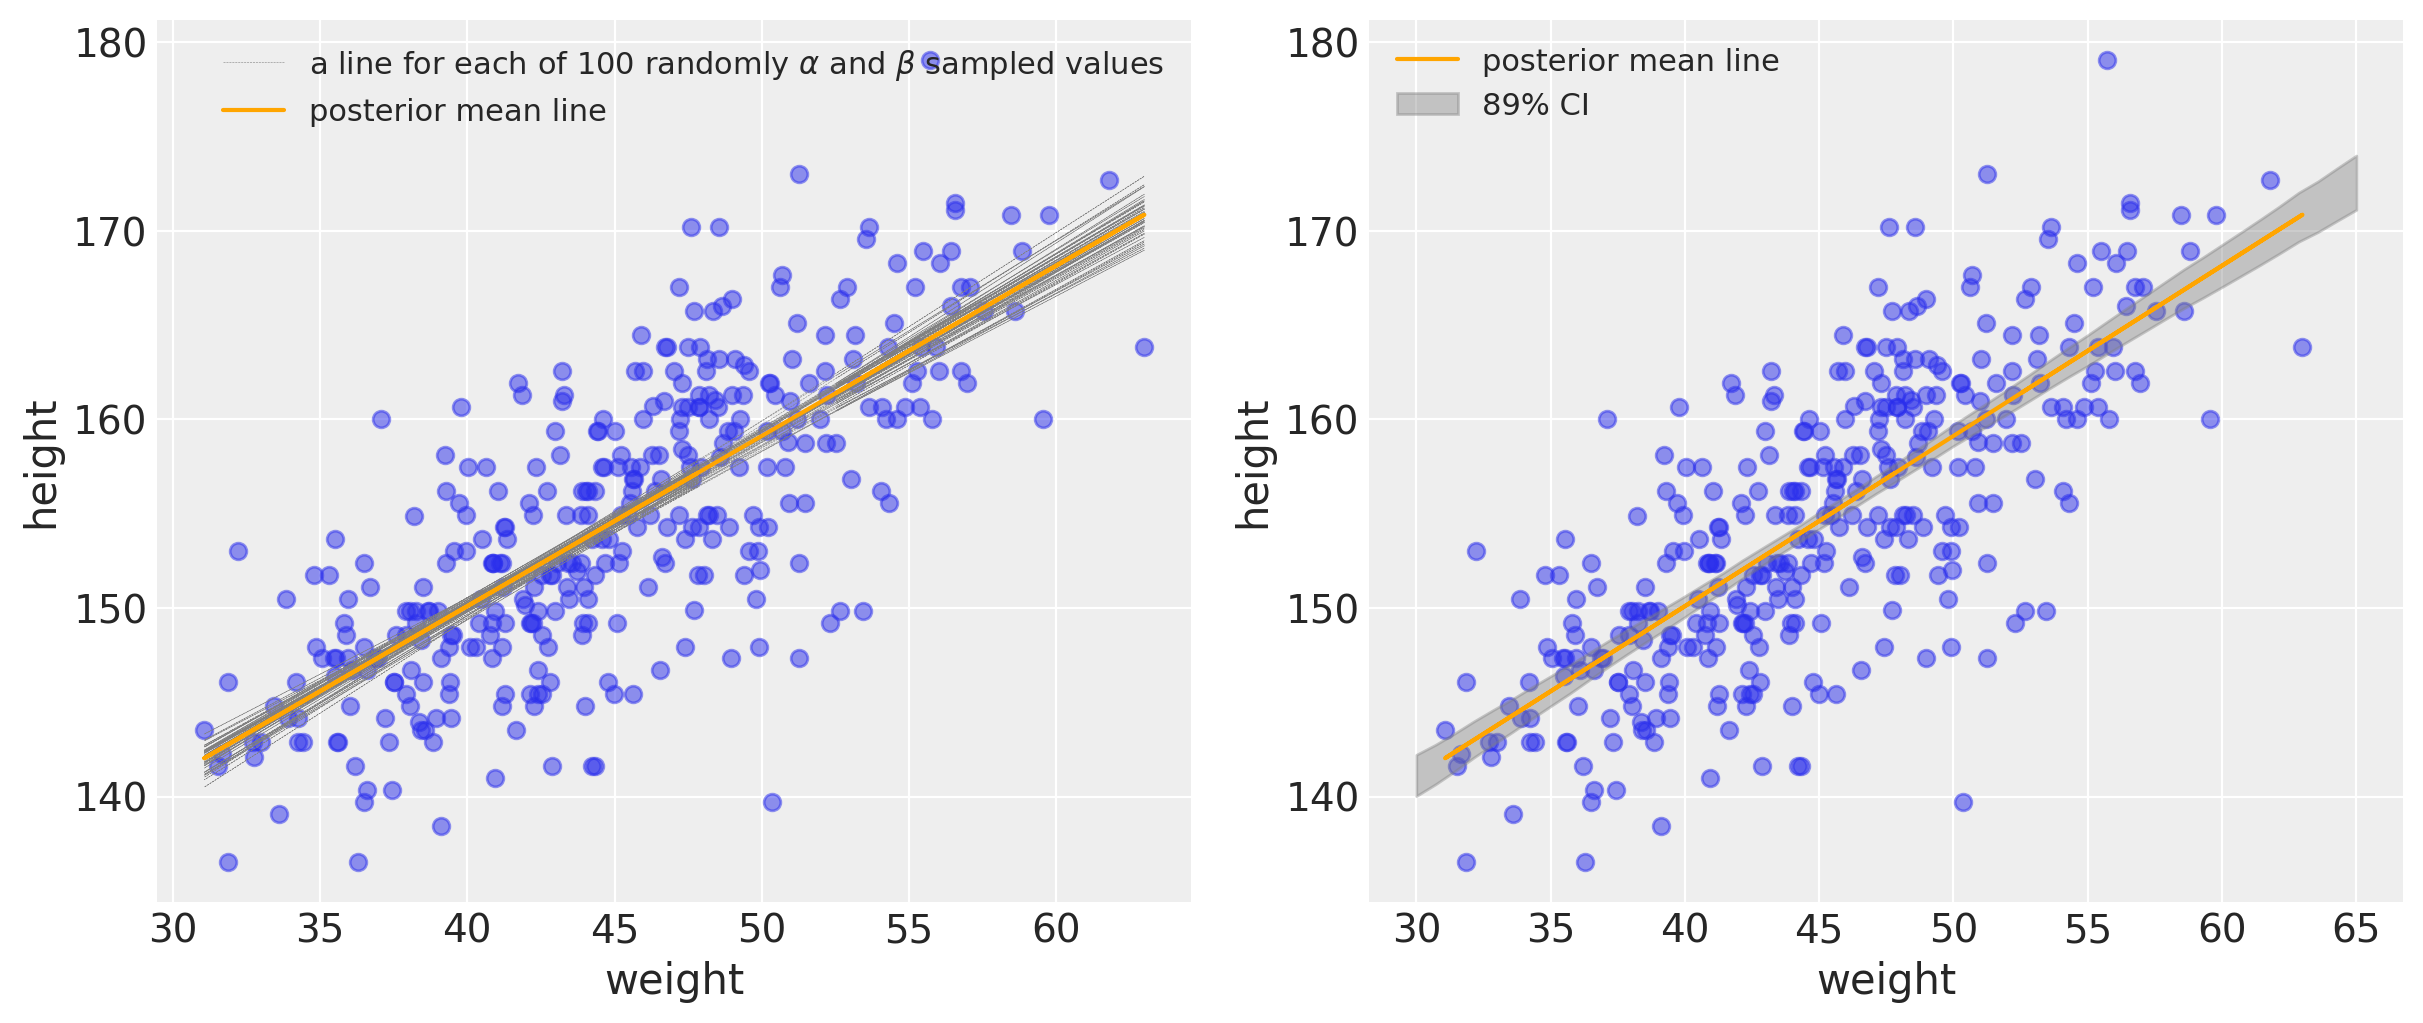

<IPython.core.display.Javascript object>

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ax1 plot --------------------------------------------
# Plotting the data as a scatter plot
ax1.scatter(d2["weight"], d2["height"], alpha=0.5)

# Plotting mean lines using the first 50 sampled values for alpha and beta parameters
# note that sigma is not used
for i in range(50):
    ax1.plot(
        d2["weight"],
        trace_m2_df["a"][i] + trace_m2_df["b"][i] * (d2["weight"] - xbar),
        color="gray",
        linewidth=0.2,
        linestyle="dashed",
    )

# Plotting the 50th for labeling purposes
ax1.plot(
    d2["weight"],
    trace_m2_df["a"][i] + trace_m2_df["b"][i] * (d2["weight"] - xbar),
    color="gray",
    linewidth=0.2,
    linestyle="dashed",
    label=r"a line for each of 100 randomly $\alpha$ and $\beta$ sampled values",
)

# Plotting the overall mean line
ax1.plot(
    d2["weight"],
    trace_m2["a"].mean() + trace_m2["b"].mean() * (d2["weight"] - xbar),
    label="posterior mean line",
    color="orange",
)

ax1.set_xlabel("weight")
ax1.set_ylabel("height")
ax1.legend(fontsize=11)


# ax2 plot --------------------------------------------
# Plotting the data as a scatter plot
ax2.scatter(d2["weight"], d2["height"], alpha=0.5)

ax2.fill_between(
    np.linspace(30, 65),
    cred_intervals[:, 0],
    cred_intervals[:, 1],
    alpha=0.4,
    color="gray",
    label="89% CI",
)

# Plotting the overall mean line
ax2.plot(
    d2["weight"],
    trace_m2["a"].mean() + trace_m2["b"].mean() * (d2["weight"] - xbar),
    label="posterior mean line",
    color="orange",
)

ax2.set_xlabel("weight")
ax2.set_ylabel("height")
ax2.legend(fontsize=11)

It's important to remember that the orange line drawn represents the posterior **mean** line. It is the most plausible line, but it's helpful to keep in mind that there's uncertainty and other lines (gray) are plausible (albeit with lower probability).

## Understanding $\mu_i$ uncertainty at a single weight value

It might still be hard to see why we'd have uncertainty around a *mean* value. Let's take only one weight, 45 kg. We can use the formula for our line and simply plug in the value of 45 for $x_i$. We will get back a vector of predicted means since $\alpha$ and $\beta$ are vectors. Again, note how $\sigma$ from our posterior distribution is still not used in this equation.

In [13]:
mu_at_45 = trace_m2_df["a"] + trace_m2_df["b"] * (45 - xbar)
mu_at_45

0       154.038708
1       153.978171
2       155.120183
3       154.114503
4       154.336424
           ...    
3995    154.535375
3996    154.517126
3997    154.868261
3998    154.294376
3999    154.882975
Length: 4000, dtype: float64

<IPython.core.display.Javascript object>

We can plot the uncertainty around this *single* weight value.

In [14]:
# Get 89% compatibility interval
az.hdi(np.array(mu_at_45))

array([154.18730325, 155.06312313])

<IPython.core.display.Javascript object>

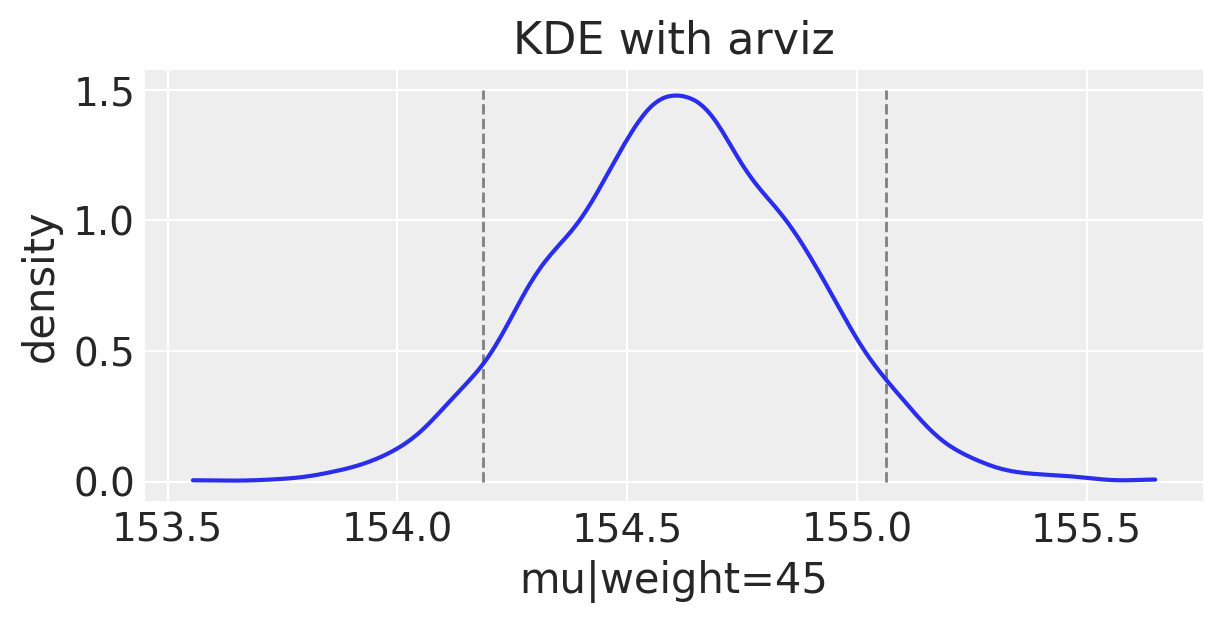

<IPython.core.display.Javascript object>

In [15]:
f, ax1 = plt.subplots(1, 1, figsize=(6, 3))

az.plot_kde(mu_at_45, ax=ax1)
ax1.set_title("KDE with arviz")
ax1.set_ylabel("density")
ax1.set_xlabel("mu|weight=45")
ax1.vlines(
    az.hdi(np.array(mu_at_45)),
    ymin=0,
    ymax=1.5,
    color="gray",
    linestyle="dashed",
    linewidth=1,
)

## Understanding $\mu_i$ uncertainty for a range weight values

Now let's take a look at a range of weight values.

This is taken from the repo: "We are doing manually, in the book is done using the `link` function. In the book on code 4.58 the following operations are performed manually."

In [16]:
# Input a range of weight values
weight_seq = np.arange(25, 71)

# Given that we have a lot of samples we can use less of them for plotting
# I just decided to use them all
# trace_m_thinned = trace_m2_df[::10]

# This is generating a matrix where the predicted mu values will be kept
# Each weight value will be its own row
mu_pred = np.zeros((len(weight_seq), len(trace_m2_df)))

# Fill out the matrix in this loop
for i, w in enumerate(weight_seq):
    mu_pred[i] = trace_m2_df["a"] + trace_m2_df["b"] * (w - d2["weight"].mean())

<IPython.core.display.Javascript object>

The line for `mu_pred` can use further explanation. Unlike the example above where `mu` was a vector when evaluating at had for a single weight value, we will now return a matrix. (While I didn't explicitly think to use this, this [Stack Overflow link](https://stackoverflow.com/questions/49825216/what-is-a-chain-in-pymc3) explains how MCMC uses multiple chains.)

In [17]:
df_mu_pred = pd.DataFrame(mu_pred, index=weight_seq)
df_mu_pred.index.name = "weight"
df_mu_pred.head()

,0,1,2,3,4,5,6,7,8,9,...,3990,3991,3992,3993,3994,3995,3996,3997,3998,3999
weight,,,,,,,,,,,,,,,,,,,,,
25,136.962955,136.745789,135.964799,137.339942,137.070195,136.391014,137.400020,135.540841,137.229818,137.229818,...,136.792754,134.847379,137.340286,136.769336,136.288645,137.023925,136.252638,137.547335,135.652358,138.084570
26,137.816743,137.607408,136.922568,138.178670,137.933506,137.315978,138.263711,136.470338,138.117891,138.117891,...,137.680154,135.815304,138.230857,137.690492,137.214395,137.899497,137.165862,138.413381,136.584459,138.924490
27,138.670531,138.469027,137.880337,139.017398,138.796818,138.240943,139.127403,137.399836,139.005963,139.005963,...,138.567553,136.783228,139.121427,138.611649,138.140145,138.775070,138.079087,139.279427,137.516560,139.764410
28,139.524318,139.330647,138.838106,139.856126,139.660129,139.165907,139.991094,138.329334,139.894036,139.894036,...,139.454953,137.751152,140.011998,139.532806,139.065895,139.650642,138.992311,140.145474,138.448661,140.604330
29,140.378106,140.192266,139.795876,140.694854,140.523441,140.090872,140.854786,139.258832,140.782108,140.782108,...,140.342353,138.719077,140.902569,140.453963,139.991645,140.526215,139.905535,141.011520,139.380762,141.444251


<IPython.core.display.Javascript object>

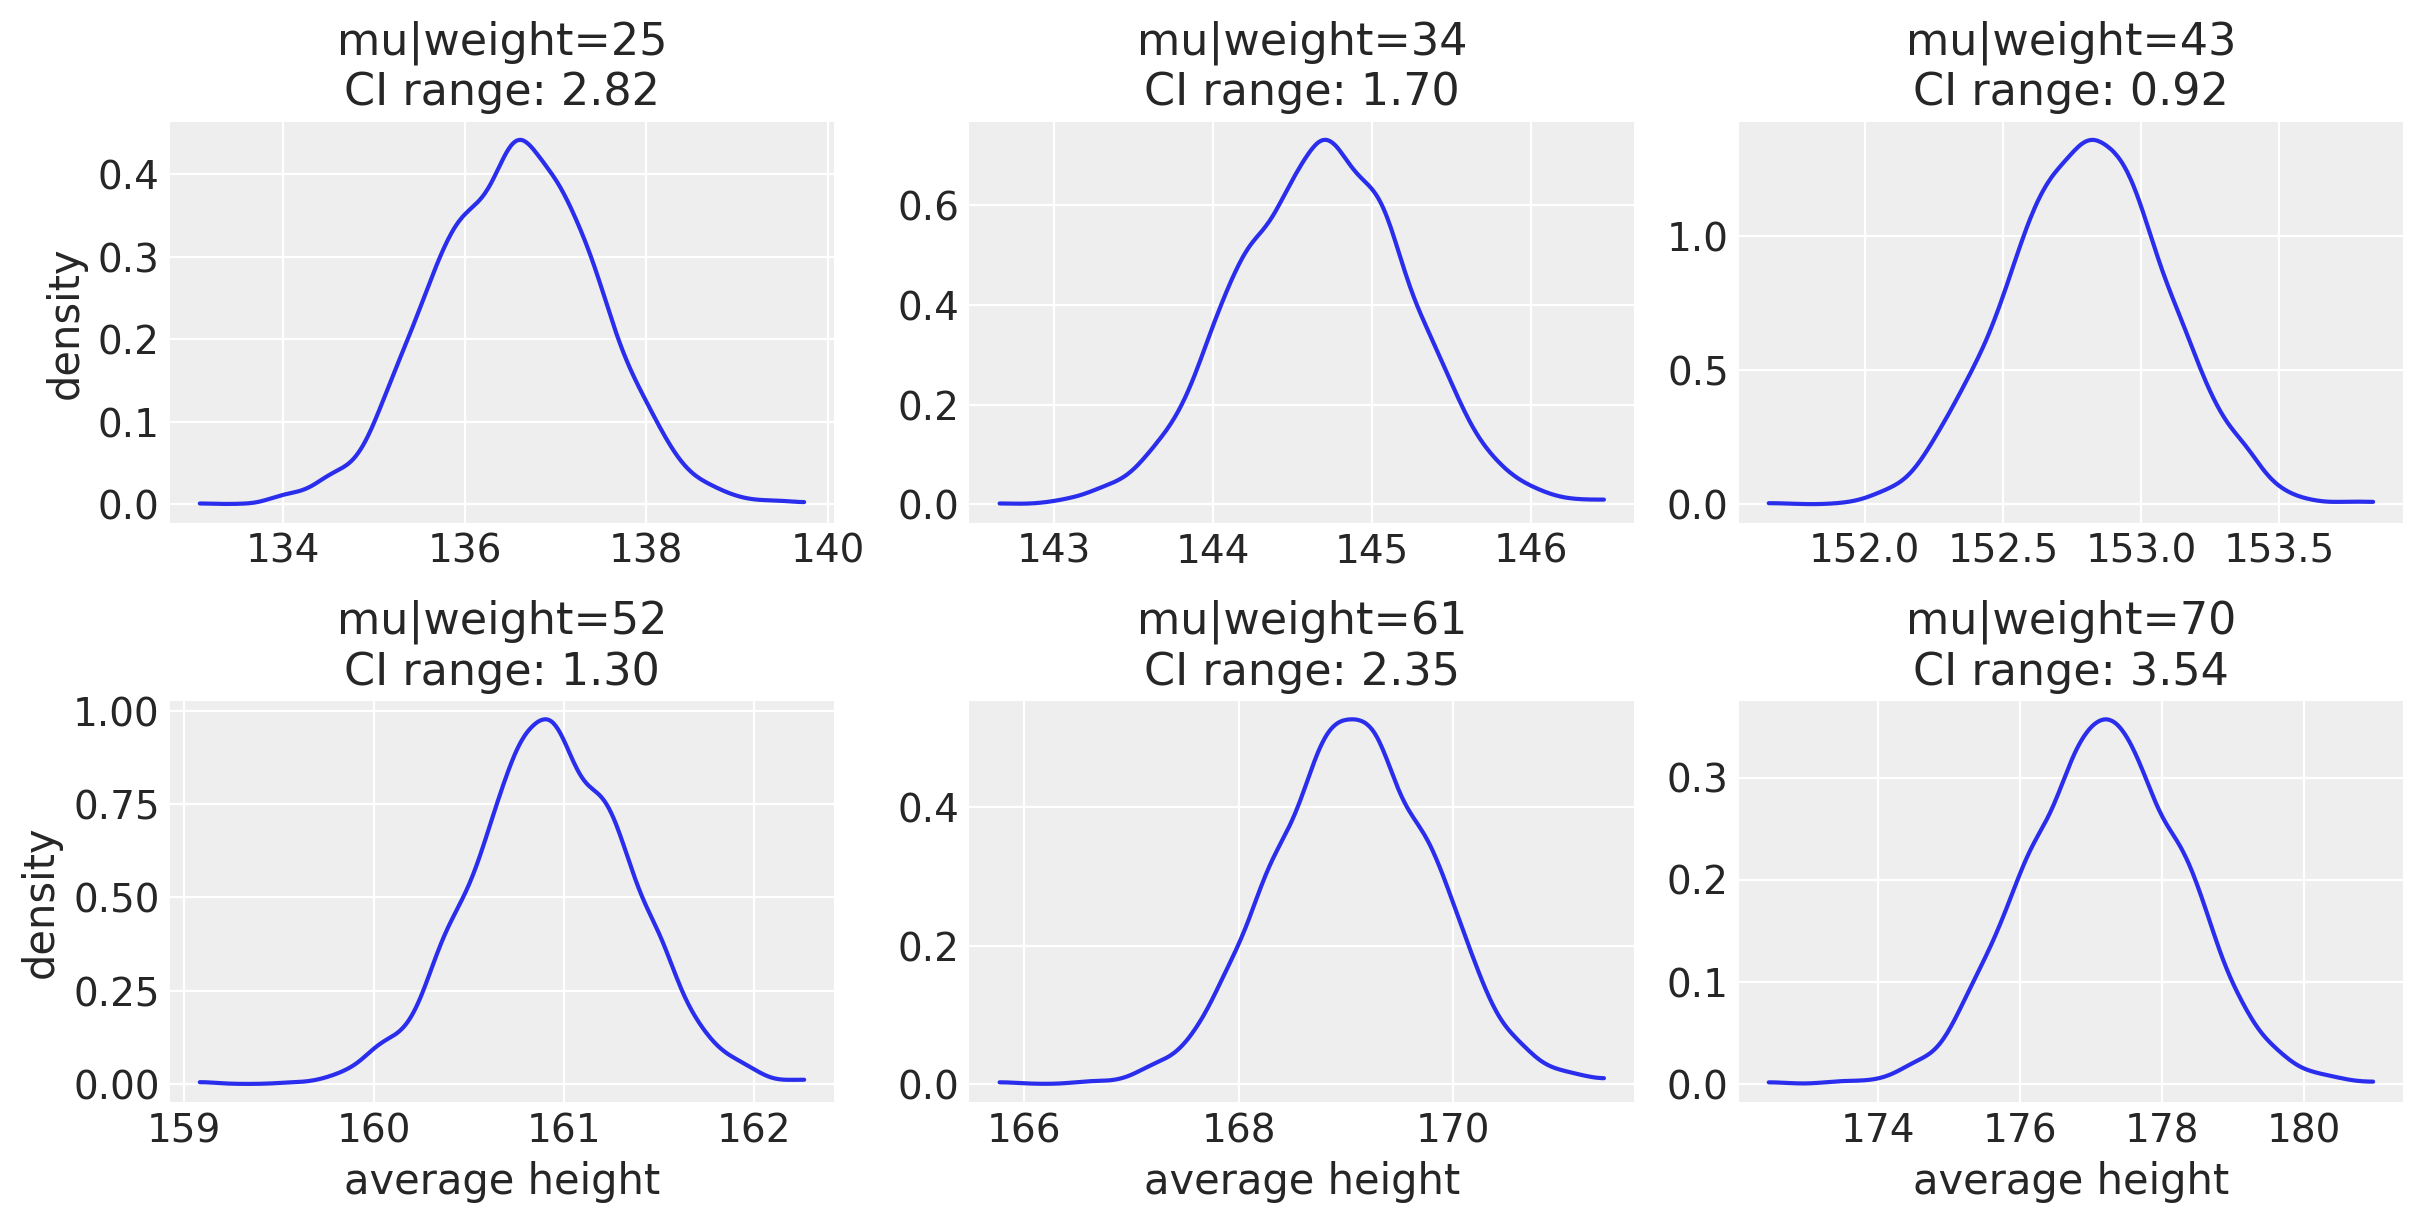

<IPython.core.display.Javascript object>

In [18]:
f, axes = plt.subplots(2, 3, figsize=(12, 6))

# equally spaced weights weights in the weight range
arb_weights = np.linspace(25, 70, 6)

for arb_weight, ax in zip(arb_weights, axes.flat):
    comp_interval = az.hdi(np.array(df_mu_pred.loc[arb_weight]))
    legend_label = "CI range: {0:0.2f}".format(np.diff(comp_interval)[0])
    az.plot_kde(df_mu_pred.loc[arb_weight], ax=ax)
    ax.set_title("mu|weight=%i" % arb_weight + "\n" + legend_label)
    # ax.legend()  # cleaner to put as the title
    if ax.is_first_col():
        ax.set_ylabel("density")
    if ax.is_last_row():
        ax.set_xlabel("average height")

This is another way of looking at the variability for average height. The compatibility interval range (CI range) is showing how bigger the CI is when looking at either end of the weight range. Here is a more intuitive way of showing this, with the data points in blue.

Text(0.5, 1.0, 'Uncertainty of $\\mu_i$, the linear model of the mean')

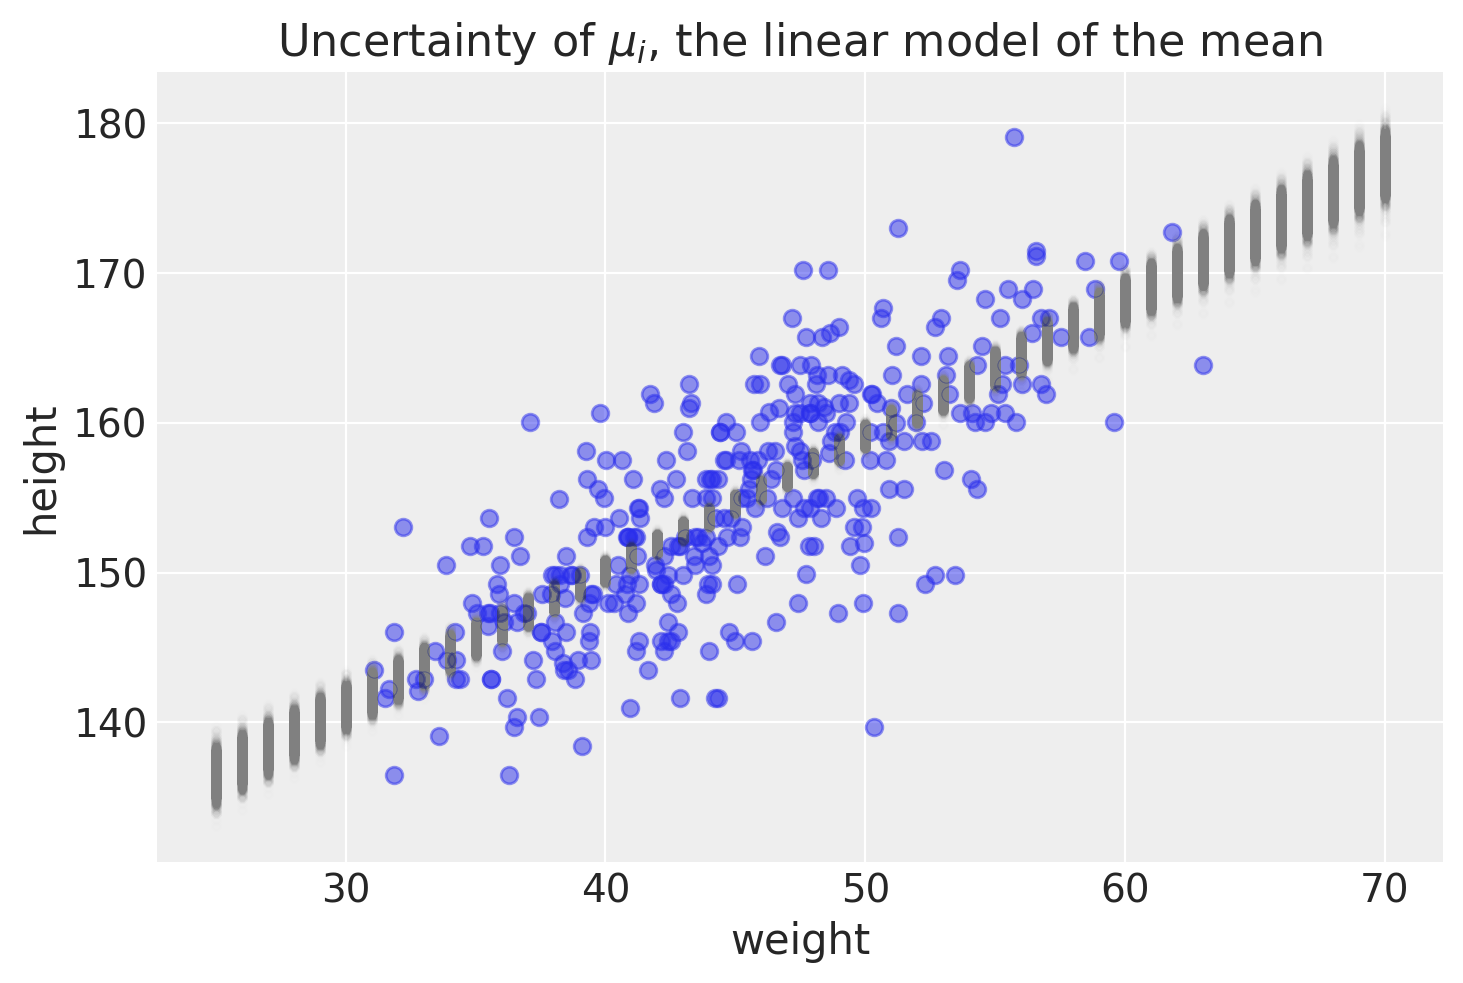

<IPython.core.display.Javascript object>

In [19]:
# Plotting the data as a scatter plot
plt.scatter(d2["weight"], d2["height"], alpha=0.5)
plt.plot(weight_seq, mu_pred, "C0.", color="gray", alpha=0.005)
plt.xlabel("weight")
plt.ylabel("height")
plt.title(r"Uncertainty of $\mu_i$, the linear model of the mean")

# Summary

The purpose of this post was to show how to make predictions on average height using `pymc`. We used our posterior distribution to make many different regression lines. We plotted the uncertainties of average height around individual weights to appreciate this point. One thing that I have stressed is making a distinction between average height versus actual height. The last figure highlights how making predictions on average height would lead to over-confidence in where a *new* point may lie. In the next post, we will use the posterior distribution to make predictions on actual height.

Appendix: Environment and system parameters

In [20]:
%watermark -n -u -v -iv -w

Last updated: Sun May 16 2021

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.20.0

pandas    : 1.2.1
matplotlib: 3.3.4
pymc3     : 3.11.0
seaborn   : 0.11.1
scipy     : 1.6.0
arviz     : 0.11.1
json      : 2.0.9
numpy     : 1.20.1

Watermark: 2.1.0



<IPython.core.display.Javascript object>